In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
from tfdnr import tfd_noise_rejection
from collections import defaultdict
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
with segyio.open('data/01_test_shots.sgy', ignore_geometry=True) as f:
    field_records = f.attributes(segyio.TraceField.FieldRecord)
    unique_field_records = np.unique(field_records)
    dt = f.bin[segyio.BinField.Interval] * 1e-06
    n_samples = f.bin[segyio.BinField.Samples]    
    
    # Создаем словарь с помощью defaultdict
    tracemap = defaultdict(list)
    
    # Заполняем словарь: ключ - FieldRecord, значение - список номеров трасс
    for trace_num, field_record in enumerate(tqdm(field_records), start=1):
        tracemap[field_record].append(trace_num)
    
    all_traces = f.trace.raw[:]

100%|██████████| 11446/11446 [00:00<00:00, 195165.59it/s]


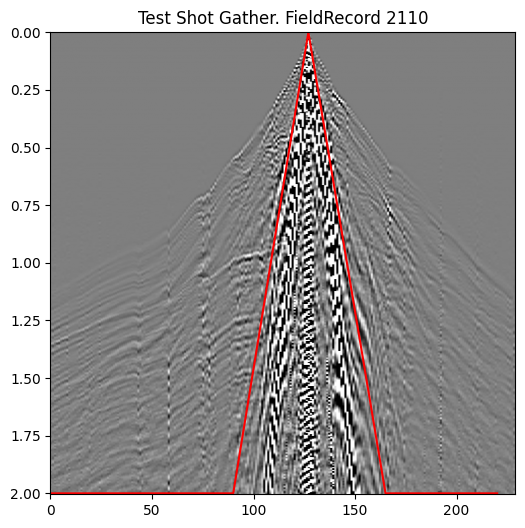

In [3]:
fr = unique_field_records[10]
indices = tracemap[fr]
test_gather = all_traces[indices]
adj_wnd = np.array([[0, 2.0], [90, 2.0], [127, 0.0], [165,2.0], [220, 2.0]])
vmin, vmax = np.percentile(test_gather, [3, 97])
plt.figure(figsize=(6, 6))
plt.title(f'Test Shot Gather. FieldRecord {fr}')
plt.imshow(test_gather.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray', extent=(0, test_gather.shape[0], n_samples*dt, 0))
plt.plot(adj_wnd[:,0], adj_wnd[:, 1], color='red')

In [4]:
def compare_plot(orig, proc, title):
    diff = orig - proc
    vmin, vmax = np.percentile(orig, [3, 97])
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
    fig.suptitle(title)
    for data, ax, subtitle in zip([orig, proc, diff], axes, ['Original', 'Processed', 'Difference']):
        ax.set_title(subtitle)
        ax.imshow(data.T, vmin=vmin, vmax=vmax, cmap='gray', aspect='auto')
    fig.tight_layout()

Signal length: 501 samples, 2.004 seconds
Adjustment line range: 0 - 500 samples
STFT parameters: 64 time frames, hop_length=8
Signal length: 501 samples, 2.004 seconds
Adjustment line range: 0 - 500 samples
STFT parameters: 64 time frames, hop_length=8


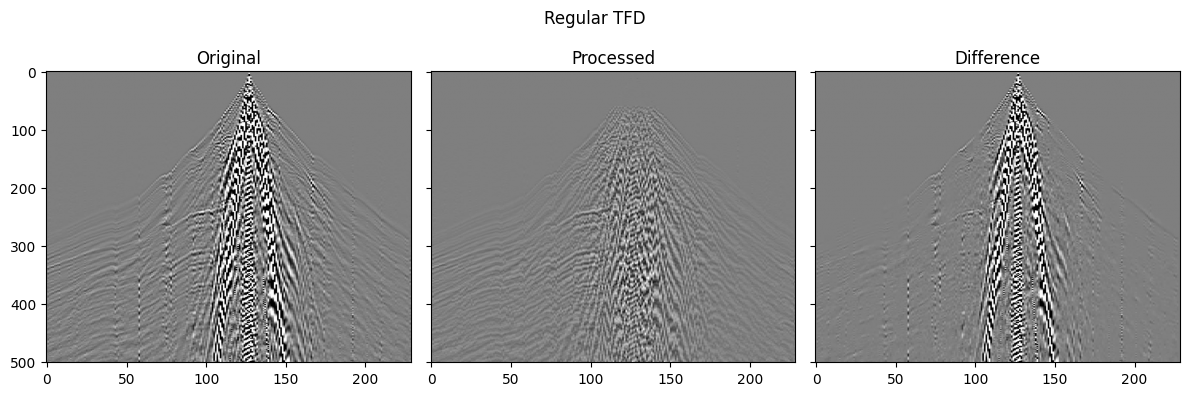

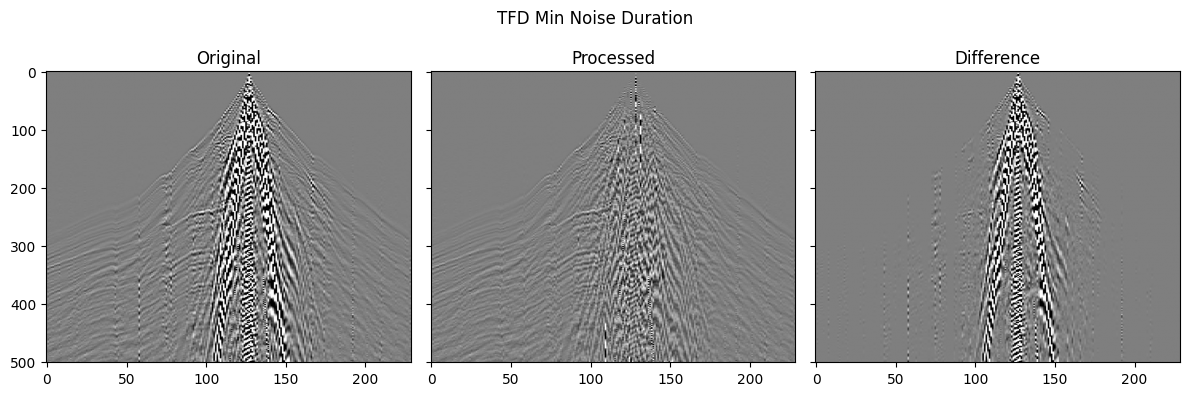

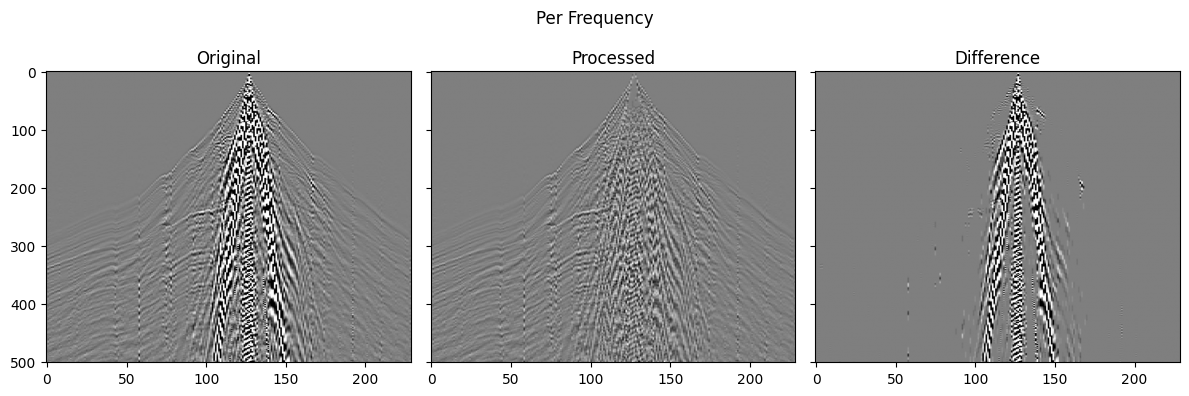

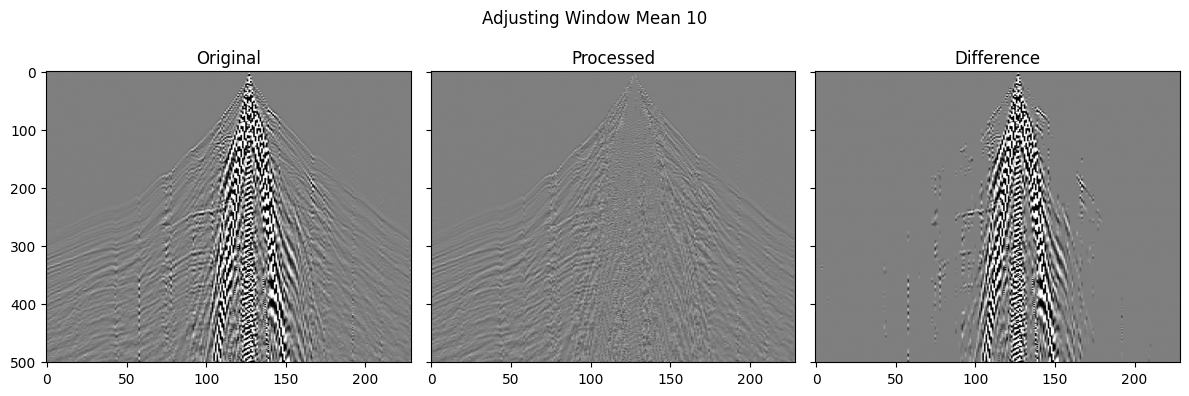

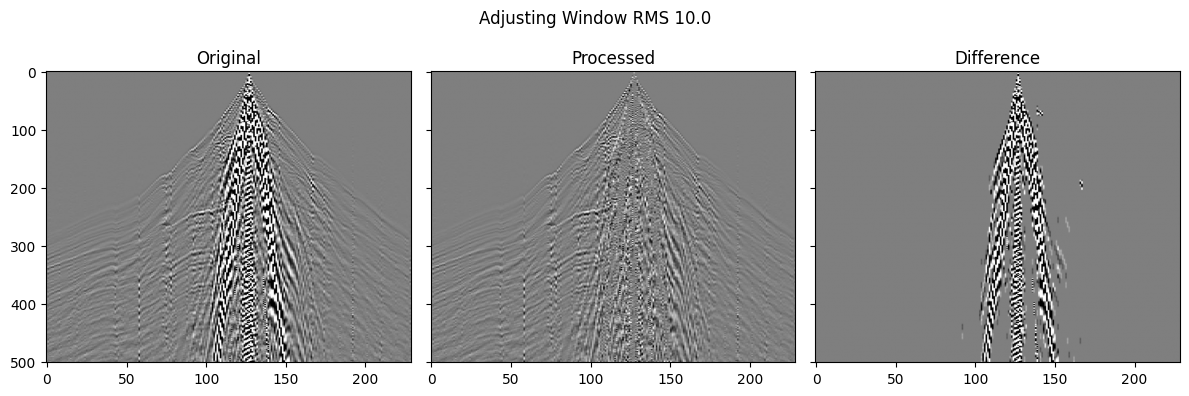

In [ ]:
test_gather_proc1 = tfd_noise_rejection(
    data=test_gather,
    stft_window_ms=64,
    dt=dt,
    trace_aperture=30,
    threshold_multiplier=10.0,
    method='median_filter'
)
compare_plot(test_gather, test_gather_proc1, 'Regular TFD, Threshold Amp=10.0')

test_gather_proc2 = tfd_noise_rejection(
    data=test_gather,
    stft_window_ms=64,
    dt=dt,
    trace_aperture=30,
    threshold_multiplier=10.0,
    method='median_filter',
    min_noise_duration_ms=500
)
compare_plot(test_gather, test_gather_proc2, 'TFD Min Noise Duration=500, Threshold Amp=10.0')

test_gather_proc3 = tfd_noise_rejection(
    data=test_gather,
    stft_window_ms=64,
    dt=dt,
    trace_aperture=30,
    threshold_multiplier=10.0,
    method='median_filter',
    threshold_method='per_frequency'
)
compare_plot(test_gather, test_gather_proc3, 'Per Frequency, Threshold Amp=10.0')

test_gather_proc4 = tfd_noise_rejection(
    data=test_gather,
    stft_window_ms=64,
    dt=dt,
    method='adjustment_window',
    adjustment_points=adj_wnd,
    window_type='above',
    adj_wnd_mode='mean',
    threshold_multiplier=10.0
)
compare_plot(test_gather, test_gather_proc4, 'Adjusting Window Mean 10, Threshold Amp=10.0')

test_gather_proc5 = tfd_noise_rejection(
    data=test_gather,
    stft_window_ms=64,
    dt=dt,
    method='adjustment_window',
    adjustment_points=adj_wnd,
    window_type='above',
    adj_wnd_mode='RMS',
    threshold_multiplier=10.0
)
compare_plot(test_gather, test_gather_proc5, 'Adjusting Window RMS, Threshold Amp=10.0')